In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from rich import print

from astroquery.mpc import MPC
from astropy.coordinates import SkyCoord
from astropy import units as u

import ssptools

from matplotlib.colors import Normalize 
from scipy import interpolate
from matplotlib import cm

import mpl_scatter_density # adds projection='scatter_density'

In [71]:
obs_tab = MPC.get_observatory_codes()
dict_obs = {}
for key, val in obs_tab['Code', 'Name']:
    dict_obs[key] = val
dict_obs
df_observatory_band = pd.read_csv('./data/df_observatory_band.csv', index_col=[0, 1])
obs_tab = MPC.get_observatory_codes()
dict_obs = {}
for key, val in obs_tab['Code', 'Name']:
    dict_obs[key] = val


# Estimation of the astrometry difference

In [119]:
# Load data and computing coordinate differences
idx = 0
k = 100
dx = 10
issave = True
path = f'./data/observatories/'

for i, (idx, row) in enumerate(df_observatory_band[idx:].iterrows()):
    observatory, band = idx
    name = f'{observatory}_{band}'

    # Loading data
    df_obs = pd.read_parquet(os.path.join(path, 'observations_corr_mag', 
        f'obs_{name}_corr_mag.parquet'), 
        columns=['epoch', 'RA_x', 'DEC_x', 'RA_y', 'DEC_y']
                 )
    df_obs.sort_values('epoch', inplace=True)

    # df_obs = df_obs[1:]
    # print('Converting coordinates to decimal degrees')
    k = df_obs.shape[0]//100_000 + 1
    coords = SkyCoord(ra=df_obs['RA_y'].values[::k], dec=df_obs['DEC_y'].values[::k], 
                      unit=(u.hourangle, u.deg))
    # df_obs['RA_z'] = coords.ra.deg
    # df_obs['DEC_z'] = coords.dec.deg

    alpha = 1.0/np.sqrt(df_obs.__len__()/k)*100
    alpha = float(np.where(alpha > 1, 1, alpha))

    fig, ax = plt.subplots()
    # plt.scatter((df_obs['RA_x'] - df_obs['RA_z'])*3600, 
    #             (df_obs['DEC_x'] - df_obs['DEC_z'])*3600, 
    #             s=1, edgecolors='none', alpha=alpha,
    #             c=df_obs['epoch'], cmap='jet')

    im = ax.scatter((df_obs['RA_x'].values[::k] - coords.ra.deg)*3600, 
                (df_obs['DEC_x'].values[::k] - coords.dec.deg)*3600, 
                s=1, edgecolors='none', alpha=alpha,
                c=df_obs['epoch'].values[::k], cmap='jet')


    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)

    plt.xlabel('RA difference (arcsec)')
    plt.ylabel('DEC difference (arcsec)')
    plt.title(f'Observatory: {dict_obs[observatory]}, Band: {band}')
    plt.grid(alpha=0.2)
    plt.gca().set_aspect('equal')
    plt.xlim(-dx, dx)
    plt.ylim(-dx, dx)
    cbar = fig.colorbar(im, ax=ax)
    cbar.solids.set(alpha=1)
    cbar.set_label('Epoch')

    if issave:
        plt.savefig(f'./figs/astrometry/diff_{observatory}_{band}.png',
                    dpi=150, facecolor='white', bbox_inches='tight')
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

    if i % 10 == 0:
        print(f'Processed observatorie {observatory}, band {band}')

    # break


# Merging observatories data

In [3]:
df_observatory_band.index.levels[0].values, df_observatory_band.index.levels[0].shape

(array(['106', '291', '566', '599', '608', '644', '645', '683', '689',
        '691', '699', '703', '704', '926', '950', 'A14', 'A24', 'A50',
        'C41', 'C51', 'C57', 'C94', 'D00', 'D29', 'E12', 'F51', 'F52',
        'G45', 'G92', 'G96', 'H15', 'I41', 'J04', 'J43', 'J75', 'K19',
        'K95', 'M22', 'N86', 'P07', 'Q60', 'T05', 'T08', 'V00', 'W68',
        'W84', 'W92', 'W94', 'W98', 'Y00', 'Z22'], dtype=object),
 (51,))

In [4]:
path = os.path.join(f'./data/observatories/', 'observations_init')
scan = os.scandir(path)
file_list = [f.path for f in scan if f.is_file() and f.name.endswith('.parquet')]
file_list.sort()
# file_list

In [5]:
# Gathering all observations
path = os.path.join(f'./data/observatories/', 'observations_init')
scan = os.scandir(path)
file_list = [f.path for f in scan if f.is_file() and f.name.endswith('.parquet')]
file_list.sort()

for observatory in df_observatory_band.index.levels[0].values[5:]:
    # Selecting only the same observatory data
    # print(observatory)
    if os.path.exits(f'./data/astrometry/{observatory}/'):
        os.makedirs(f'./data/astrometry/{observatory}/')

    observatories = [x for x in file_list if f'_{observatory}_' in x]
    for i, file in enumerate(observatories):
        # print(file)
        df_obs = pd.read_parquet(file,
            columns=['epoch', 'RA_x', 'DEC_x', 'name', 'number']
                    )
        if i == 0:
            df_obs_all = df_obs
        else:
            df_obs_all = pd.concat([df_obs_all, df_obs])

    # Selecting only objects with more than 10 observations    
    df_val = df_obs_all.value_counts('number')
    df_val = df_val[df_val > 10]

    # Getting the data from Miriade for each asteroid
    for ast_number in df_val.index[:1]:
        file_path = os.path.join('./data/astrometry/', f'{ast_number:06d}.csv')
        if os.path.exists(file_path):
            print(f'[red]{file_path} exists.[/red]')
            continue

        cond = df_obs_all['number'] == ast_number
        df_mpc = df_obs_all[cond].reset_index(drop=True)
        epoch_list = df_mpc['epoch'].to_list()
        print(f'Getting {len(df_mpc)} the data from Miriade for {observatory} ...')
        try:
            # print(observatory, ast_number)
            df_miriade = ssptools.ephemcc(ident=ast_number, ep=epoch_list)
            coords = SkyCoord(ra=df_miriade['RA'].values, 
                              dec=df_miriade['DEC'].values, 
                      unit=(u.hourangle, u.deg))
            df_miriade['RA_z'] = coords.ra.deg
            df_miriade['DEC_z'] = coords.dec.deg
        except Exception as e:
            print(f'[blue]Error getting Miriade data for {ast_number}.[/blue]')
            print(e)
            continue
        if type(df_miriade) == bool:
            print(f'[blue]No Miriade data for {ast_number}.[/blue]')
            continue
        print(f'Done. {df_miriade.shape[0]} observations.')
        df_ast = pd.merge(df_mpc, df_miriade, left_index=True, right_index=True)
        df_ast.to_csv(file_path, index=False)
        # print(f'Saved {file_path}.')
        break

    break


644

./data/observatories/observations_init/obs_644_0_data.parquet

./data/observatories/observations_init/obs_644_R_data.parquet

./data/astrometry/005001.csv exists.

Getting 153 the data from Miriade ...

644 5001

Done. 153 observations.

Saved ./data/astrometry/005001.csv.

number
5001      153
40159      90
10152      90
10016      87
25412      84
         ... 
232356     11
206058     11
595244     11
298129     11
366524     11
Name: count, Length: 13280, dtype: int64

# Load and ploting the corrected astrometry data

In [61]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 
                              0.5*(y_e[1:]+y_e[:-1]) ) , 
                              data , np.vstack([x,y]).T , 
                            #   method = "splinef2d", 
                              method = "linear",
                              bounds_error = False)

    # z *= 1_000_000_000
    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    # print(z)

    ax.scatter( x, y, c=z, **kwargs )

    # norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    # cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    # cbar.ax.set_ylabel('Density')

    return ax


In [86]:
# Load data and computing coordinate differences
observatory = '608'
path = f'./data/astrometry/{observatory}/'

scan = os.scandir(path)
file_list = [f.path for f in scan if f.is_file() and f.name.endswith('.csv')]
file_list.sort()

for i, file in enumerate(file_list):
    if i == 0:
        df_obs = pd.read_csv(file)
    else:
        df = pd.read_csv(file)
        df_obs = pd.concat([df_obs, df])

df_obs

epoch        RA_x      DEC_x   name  number        RA_z      DEC_z  \
0   2.451701e+06  227.816375  -9.047778      5       5  227.816642  -9.047850   
1   2.451701e+06  227.814542  -9.047667      5       5  227.814838  -9.047779   
2   2.451701e+06  227.812792  -9.047583      5       5  227.813048  -9.047708   
3   2.452041e+06  325.310208 -12.074333      5       5  325.310482 -12.074642   
4   2.452041e+06  325.312042 -12.073750      5       5  325.312320 -12.074102   
..           ...         ...        ...    ...     ...         ...        ...   
37  2.453301e+06   12.055625  -2.674028  86797   86797   12.055947  -2.673962   
38  2.453301e+06   12.053583  -2.675083  86797   86797   12.053824  -2.674901   
39  2.453313e+06   10.160000  -3.455139  86797   86797   10.160111  -3.455036   
40  2.453313e+06   10.158792  -3.455528  86797   86797   10.158774  -3.455454   
41  2.453313e+06   10.157167  -3.455861  86797   86797   10.157373  -3.455892   

      VMag  
0   10.764  
1   10.765  
2   10.765  
3   12.722  
4   12.722  
..     ...  
37  18.189  
38  18.189  
39  18.564  
40  18.565  
41  18.565  

[8273 rows x 8 columns]

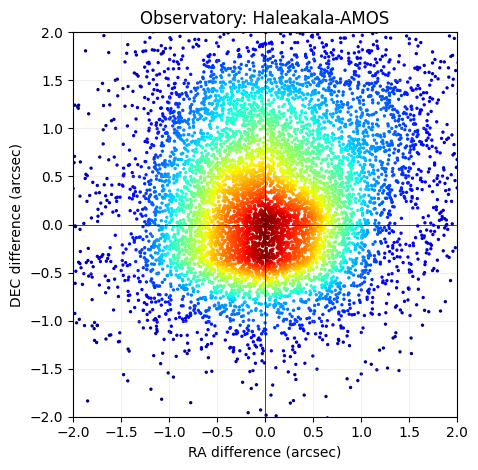

In [87]:
k = 100
dx = 2
issave = False

df_obs.sort_values('epoch', inplace=True)

k = df_obs.shape[0]//100_000 + 1
alpha = 1.0/np.sqrt(df_obs.__len__()/k)*100
alpha = float(np.where(alpha > 1, 1, alpha))

x = (df_obs['RA_x'] - df_obs['RA_z']).values * 3600.0
x = np.where(np.abs(x) < 10, x, 0)
y = (df_obs['DEC_x'] - df_obs['DEC_z']).values * 3600.0
y = np.where(np.abs(y) < 10, y, 0)

fig, ax = plt.subplots()

density_scatter(x, y, ax = ax,
            s=2, cmap=plt.cm.jet, label='Initial')

# cb = plt.colorbar(ax=ax)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

plt.xlabel('RA difference (arcsec)')
plt.ylabel('DEC difference (arcsec)')
plt.title(f'Observatory: {dict_obs[observatory]}')
ax.grid(alpha=0.2)
ax.set_aspect('equal')
ax.set_xlim(-dx, dx)
ax.set_ylim(-dx, dx)

# cbar = fig.colorbar(ax=ax)
# cbar.solids.set(alpha=1)
# cbar.set_label('Epoch')

if issave:
    plt.savefig(f'./figs/astrometry/diff_{observatory}_{band}.png',
                dpi=150, facecolor='white', bbox_inches='tight')
    plt.close()
else:
    plt.tight_layout()
    plt.show()

if i % 10 == 0:
    print(f'Processed observatorie {observatory}, band {band}')

# break
